In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
#загружаем необходимые библиотеки
from scipy import stats
from statsmodels import stats as sms
import category_encoders as ce

In [36]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [37]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [ ]:
# Подгрузим наши данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

## 1.Знакомство с данными ##

* *hotel_address* — адрес отеля;
* *review_date* — дата, когда рецензент разместил соответствующий отзыв;
* *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* *hotel_name* — название отеля;
* *reviewer_nationality* — страна рецензента;
* *negative_review* — отрицательный отзыв, который рецензент дал отелю;
* *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;
* *positive_review* — положительный отзыв, который рецензент дал отелю;
* *review_total_positive_word_counts* — общее количество слов в положительном отзыве.
* *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;
* *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
* *total_number_of_reviews* — общее количество действительных отзывов об отеле;
* *tags* — теги, которые рецензент дал отелю;
* *days_since_review* — количество дней между датой проверки и датой очистки;
* *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* *lat* — географическая широта отеля;
* *lng* — географическая долгота отеля.

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [40]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [41]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [42]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [43]:
sample_submission.head(2)

,reviewer_score,id
0,8.359,488440
1,7.739,274649


In [44]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [45]:
#смотрим количество пропусков
df_train.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

In [46]:
print(df_train['tags'].value_counts())

tags
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                    3853
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                           3673
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                           3274
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                             2964
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                   2454
                                                                                                                                           ... 
[' Leisure trip ', ' Couple ', ' Deluxe Room with spa access ', ' Stayed 5 nights ', ' Submitted from a mobile device ']           

### Промежуточные выводы: 
- представлено 3 датасета,первый для тренировки(df_train), второй для предсказания(df_test), третий(sample_submission) - с целевой переменной (reviewer_score)
- количество значений - 515738
- признаки с типом данных object (8): hotel_address, review_date, hotel_name, reviewer_nationality, negative_review, positive_review, tags, days_since_review
- признаки с типом данных int и float (9)
- в признаках lat и lng есть пропуски(3268, менее 1% от общего числа значений)
- самый популярный отель Britannia International Hotel Canary Wharf	
- больше всего отзывов было оставлено 2 августа 2017
- чаще всего отзывы оставляли гости из Великобритании
- чаще всего гости указывали в качестве отзывов "No Negative", "No Positive"
- больше всего было ипользованы теги: ' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device
- чаще всего между проверкой и очисткой проходил 1 день

## Очистка данных

In [47]:
#ищем дубликаты в данных

# Тренировочные данные - можно удалять дубликаты
print(f'В тренировочных данных {df_train[df_train.duplicated()].shape[0]} дубликатов')
df_train.drop_duplicates(inplace=True)
print('Количество строк после удаления дубликатов: {}'.format(df_train.shape[0]))

# Тестовые данные - нельзя удалять дубликаты, только проверяем
print(f'В тестовом DataFrame {df_test[df_test.duplicated()].shape[0]} дубликатов')
# df_test.drop_duplicates(inplace=True)

В тренировочных данных 307 дубликатов
Количество строк после удаления дубликатов: 386496
В тестовом DataFrame 29 дубликатов


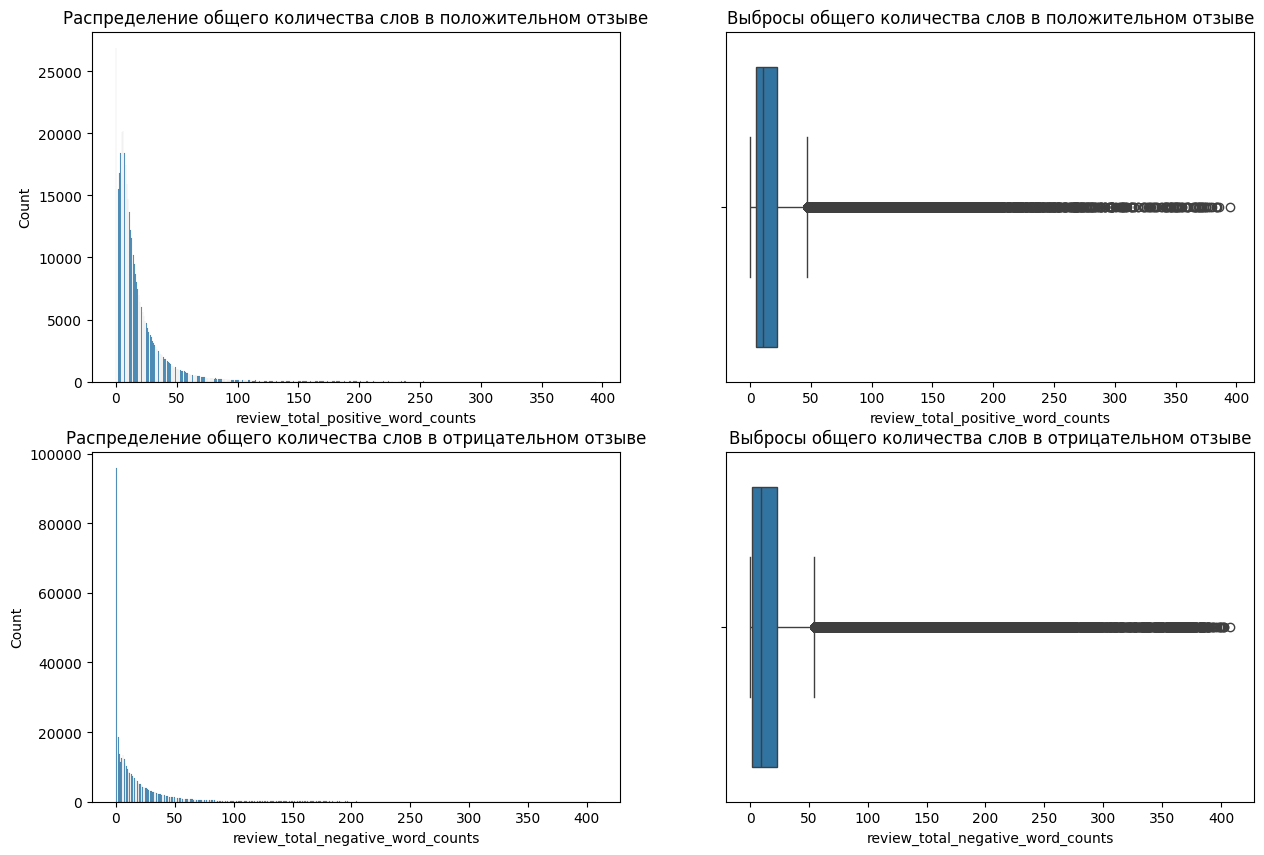

In [48]:
#посмотрим на распределение количества слов в отрицательных и положительных отзывах
fig, axes  = plt.subplots(nrows=2, ncols = 2, figsize = (15,10))
histplot = sns.histplot(data = df_train, x='review_total_positive_word_counts',ax = axes[0,0]);
histplot.set_title('Распределение общего количества слов в положительном отзыве');
boxplot = sns.boxplot(data=df_train, x = 'review_total_positive_word_counts', ax = axes[0,1]);
boxplot.set_title('Выбросы общего количества слов в положительном отзыве');
histplot = sns.histplot(data = df_train, x='review_total_negative_word_counts',ax = axes[1,0]);
histplot.set_title('Распределение общего количества слов в отрицательном отзыве');
boxplot = sns.boxplot(data=df_train, x = 'review_total_negative_word_counts', ax = axes[1,1]);
boxplot.set_title('Выбросы общего количества слов в отрицательном отзыве');


большинство отзывов содержат имеется огромное число выбросов как в числе положительных, так и в числе отрицательных отзывов

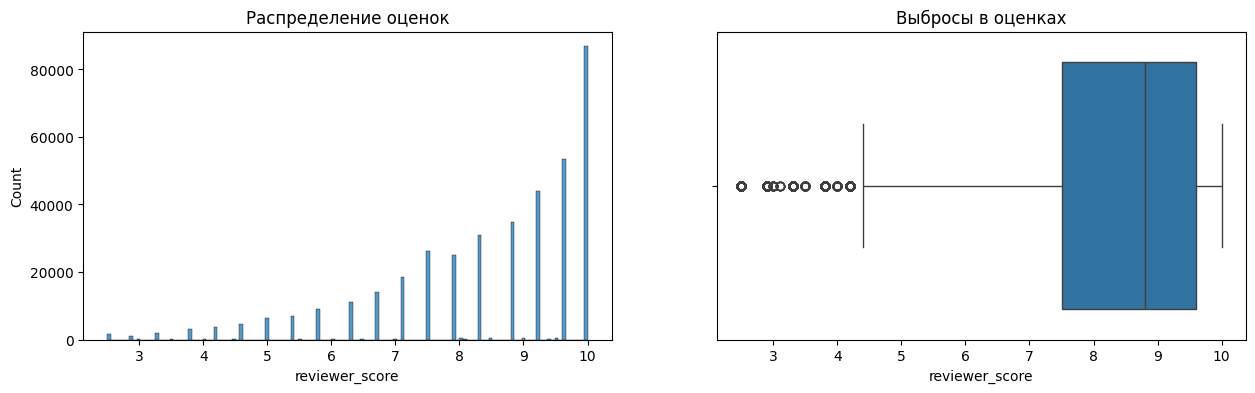

In [49]:
#ищем выбросы в данных оценок рецензентов
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df_train, x='reviewer_score', ax=axes[0]);
histplot.set_title('Распределение оценок');
boxplot = sns.boxplot(data=df_train, x='reviewer_score', ax=axes[1]);
boxplot.set_title('Выбросы в оценках');

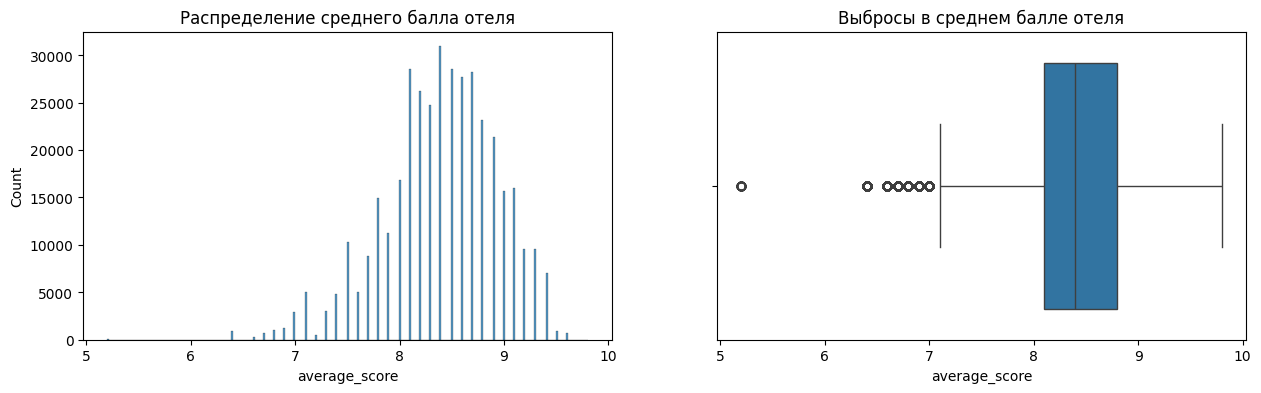

In [50]:
#ищем выбросы в данных среднего балла отеля
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df_train, x='average_score', ax=axes[0]);
histplot.set_title('Распределение среднего балла отеля');
boxplot = sns.boxplot(data=df_train, x='average_score', ax=axes[1]);
boxplot.set_title('Выбросы в среднем балле отеля');

распределение близко к нормальному, но есть выброс

In [51]:
#найдем этот выброс, это оценка меньше 6
df_train.loc[df_train['average_score']<6,]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
5666,Viale Bligny 56 Milan City Center 20136 Milan ...,26,2/17/2017,5.2,Hotel Liberty,Poland,The shower water pressure was absolutely miss...,40,465,The stuff was extremely nice The breakfast wa...,30,1,7.1,"[' Leisure trip ', ' Couple ', ' Double Room '...",167 day,45.450867,9.194866
18895,Viale Bligny 56 Milan City Center 20136 Milan ...,26,5/2/2017,5.2,Hotel Liberty,Czech Republic,No Negative,0,465,The Wi Fi was reachable near the lobby The ro...,41,6,5.4,"[' Leisure trip ', ' Couple ', ' Double Room '...",93 days,45.450867,9.194866
28330,Viale Bligny 56 Milan City Center 20136 Milan ...,26,5/25/2016,5.2,Hotel Liberty,United Kingdom,Shower box is not provided enough water and t...,14,465,Breakfast is good Weekday staff is very kind ...,16,40,5.8,"[' Leisure trip ', ' Solo traveler ', ' Single...",435 day,45.450867,9.194866
42524,Viale Bligny 56 Milan City Center 20136 Milan ...,26,10/28/2016,5.2,Hotel Liberty,United Arab Emirates,Not clean no wi fi in rooms Old furniture and...,13,465,Location is not bad,5,2,3.8,"[' Leisure trip ', ' Couple ', ' Double Room '...",279 day,45.450867,9.194866
48461,Viale Bligny 56 Milan City Center 20136 Milan ...,26,7/18/2016,5.2,Hotel Liberty,Malta,Very dirty poorly staffed Airconditioners do ...,9,465,No Positive,0,2,4.6,"[' Leisure trip ', ' Group ', ' Double Room ',...",381 day,45.450867,9.194866
51081,Viale Bligny 56 Milan City Center 20136 Milan ...,26,12/5/2016,5.2,Hotel Liberty,United Kingdom,Staff not welcoming at all Bad smell of cigar...,47,465,No Positive,0,1,2.9,"[' Leisure trip ', ' Couple ', ' Double Room '...",241 day,45.450867,9.194866
64706,Viale Bligny 56 Milan City Center 20136 Milan ...,26,4/19/2016,5.2,Hotel Liberty,Canada,Hotel looks tired and requires some updates i...,35,465,Have stayed there at least 4 times Size of mo...,39,1,6.3,"[' Business trip ', ' Solo traveler ', ' Singl...",471 day,45.450867,9.194866
75164,Viale Bligny 56 Milan City Center 20136 Milan ...,26,11/7/2016,5.2,Hotel Liberty,United Kingdom,no wi fi in the room,7,465,hotel was empty like having a private hotel,9,4,7.0,"[' Leisure trip ', ' Couple ', ' Double Room '...",269 day,45.450867,9.194866
80268,Viale Bligny 56 Milan City Center 20136 Milan ...,26,5/21/2017,5.2,Hotel Liberty,United Kingdom,Our bed wasn t made the next day The AC didn ...,55,465,The room was clean,6,1,4.2,"[' Leisure trip ', ' Couple ', ' Double Room '...",74 days,45.450867,9.194866
93707,Viale Bligny 56 Milan City Center 20136 Milan ...,26,9/18/2016,5.2,Hotel Liberty,United Kingdom,run down hotel with unmotivated staff,7,465,No Positive,0,1,4.2,"[' Leisure trip ', ' Couple ', ' Double Room '...",319 day,45.450867,9.194866


## Очистка данных

In [52]:
#чистим выбросы,будем считать, что значение выше 100 предопределяет оценку
df_train = df_train.drop(df_train.loc[df_train['review_total_positive_word_counts']>100,].index, axis = 0)

df_train = df_train.drop(df_train.loc[df_train['review_total_negative_word_counts']>100,].index, axis = 0)

Отель с оценкой меньше 6(5.2) это Hotel Liberty
Так как средний балл этого отеля сильно отличается от среднего балла большинства отелей, и количество оценок небольшое, уберем этот отель из выборки

In [53]:
liberty_hotel = df_train.loc[df_train['average_score']<6,].index
df_train = df_train.drop(liberty_hotel, axis=0)

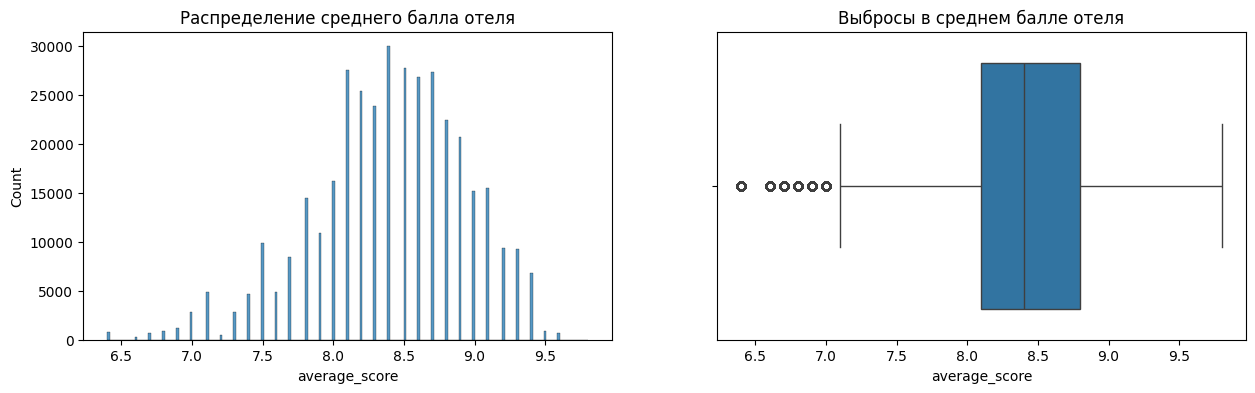

In [54]:
#посмотрим снова на график после удаления выброса
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df_train, x='average_score', ax=axes[0]);
histplot.set_title('Распределение среднего балла отеля');
boxplot = sns.boxplot(data=df_train, x='average_score', ax=axes[1]);
boxplot.set_title('Выбросы в среднем балле отеля');

In [55]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data = pd.concat([df_test, df_train], ignore_index=True).reset_index(drop=True)

## EDA

In [56]:
#преобразуем признак review_date в datatime
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=False)

#создадим новые признаки на основе даты
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month

#создадим новый признак - время года
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

data['season'] = data['review_month'].apply(month_to_season)

#кодируем новый признак
encoder = ce.OneHotEncoder(cols=['season'], use_cat_names=True)
type_bin = encoder.fit_transform(data['season'])
#объединяем данные
data = pd.concat([data, type_bin], axis=1)

In [57]:
# словарь с заменами для year
mapping = {2015: 1, 2016: 2, 2017: 3}
# производим замену значений
data['review_year'] = data['review_year'].replace(mapping)

In [58]:
# Удаляем признак 'review_date'.
data = data.drop(['review_date'], axis = 1)

In [59]:
#создадим новый признак - страна, в которой находится отель
data['country_hotel'] = data['hotel_address'].apply(lambda x: x.split()[-1])

#переименуем kingdom
data.loc[data['country_hotel'] == 'Kingdom', 'country_hotel'] = 'United Kingdom'

In [60]:
data['country_hotel'].value_counts()

country_hotel
United Kingdom    256266
Spain              58549
France             58213
Netherlands        55560
Austria            38060
Italy              36294
Name: count, dtype: int64

In [61]:
#создадим новый признак - иностранный гость или местный житель

#для начала выясним страну гостя - его национальность
display(data['reviewer_nationality'].value_counts())

#удаляем пробелы
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1] if x[0]==' ' else x)

reviewer_nationality
United Kingdom               239440
United States of America      34223
Australia                     21155
Ireland                       14410
United Arab Emirates           9989
                              ...  
Tuvalu                            1
Cape Verde                        1
Svalbard Jan Mayen                1
Northern Mariana Islands          1
Palau                             1
Name: count, Length: 227, dtype: int64

In [62]:
#создадим функцию, чтобы выяснить иностранец ли гость
def foreigner_func(hotel, reviewer):
    if hotel != reviewer:
        return 1
    else: return 0



#создаем признак иностранец
data['foreigner'] = data.apply(lambda x: foreigner_func(x['country_hotel'], x['reviewer_nationality']), axis=1)
data['foreigner'] = data['foreigner'].astype(bool)

#кодируем новый признак
bin_encoder = ce.BinaryEncoder(cols=['foreigner'])
# применяем трансформацию к столбцу
type_bin = bin_encoder.fit_transform(data['foreigner'])
# добавляем результат к исходному DataFrame
data = pd.concat([data, type_bin], axis=1)

In [63]:
#кодируем новый признак
encoder = ce.OneHotEncoder(cols=['country_hotel'], use_cat_names=True)
type_bin = encoder.fit_transform(data['country_hotel'])
#объединяем данные
data = pd.concat([data, type_bin], axis=1)

In [64]:
# удаление столбцов с координатами, в них есть пропуски и в дальнейшем они ухудщают работу модели
data = data.drop(['lat', 'lng'], axis=1)

In [65]:
#переведем признак days_since_review в числовой, для этого создадим функцию
def day_rev(days):
    day = int(days.split(' ')[0])
    return day

data['days_since_review'] = data['days_since_review'].apply(day_rev)

In [66]:
#удаляем признак 'days_since_review'
data1 = data.drop(['days_since_review'], axis = 1)

In [67]:
#создадим новый признак - город, в котором находится отель
european_capitals = [
    'Amsterdam', 'Andorra la Vella', 'Athens', 'Belgrade', 'Barcelona', 'Berlin', 'Bern',
    'Bratislava', 'Brussels', 'Bucharest', 'Budapest', 'Chisinau', 'Copenhagen',
    'Dublin', 'Helsinki', 'Istanbul', 'Kiev', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg',
    'Madrid', 'Milan', 'Minsk', 'Monaco', 'Moscow', 'Oslo', 'Paris', 'Podgorica',
    'Prague', 'Reykjavik', 'Riga', 'Rome', 'San Marino', 'Sarajevo', 'Skopje',
    'Sofia', 'Stockholm', 'Tallinn', 'Tirana', 'Vaduz', 'Valletta', 'Vienna',
    'Vilnius', 'Warsaw', 'Zagreb'
]

def get_city(address):
    for capital in european_capitals:
        if capital in address:
            return capital
    return None

data1['city'] = data1['hotel_address'].apply(get_city)

In [68]:
data1.head(3)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,foreigner,foreigner_0,foreigner_1,country_hotel_Italy,country_hotel_Netherlands,country_hotel_Spain,country_hotel_United Kingdom,country_hotel_France,country_hotel_Austria,city
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,True,0,1,1,0,0,0,0,0,Milan
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,True,0,1,0,1,0,0,0,0,Amsterdam
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,True,0,1,0,0,1,0,0,0,Barcelona


In [69]:
# закодируем признак city
city_dummies = pd.get_dummies(data1['city'], prefix='city')
data_clean = pd.concat([data1, city_dummies], axis=1)

In [70]:
#удаляем признак hotel_address
data = data_clean.drop(['hotel_address'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502942 entries, 0 to 502941
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                502942 non-null  int64  
 1   average_score                               502942 non-null  float64
 2   hotel_name                                  502942 non-null  object 
 3   reviewer_nationality                        502942 non-null  object 
 4   negative_review                             502942 non-null  object 
 5   review_total_negative_word_counts           502942 non-null  int64  
 6   total_number_of_reviews                     502942 non-null  int64  
 7   positive_review                             502942 non-null  object 
 8   review_total_positive_word_counts           502942 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  502942 non-null  int64  
 

In [71]:
#обработаем признаки positive_review, negative_review
def positive(b):
    if b == 'No Positive':
        b = 0
    else:
        b = 1
    return b

def negative(a):
    if a == 'No Negative':
        a = 0
    else:
        a = 1
    return a


data['negative_review'] = data['negative_review'].apply(negative)
data['positive_review'] = data['positive_review'].apply(positive)

In [72]:
from collections import Counter
tag_list = data['tags'].values.tolist() # столбец приводим к формату списка
tags = list() # создаем пустой список
for sublist in tag_list:
    sublist = sublist.replace("'", '')
    sublist = sublist.replace('[', '')
    sublist = sublist.replace(']', '')
    sublist = sublist.replace('  ', ' ')
    sublist = sublist.split(',')
    tags.extend(sublist)
        
cnt = Counter(tags)

In [73]:
# преобразование счетчика в словарь
tag_dict = dict(cnt) 

# преобразование словаря в DataFrame
tag_df = pd.DataFrame(list(tag_dict.items()), columns=['tag', 'count'])


In [74]:
display(tag_df.sort_values(by='count', ascending=False).head(50)) 

,tag,count
0,Leisure trip,407123
10,Submitted from a mobile device,301886
1,Couple,245883
6,Stayed 1 night,189762
3,Stayed 2 nights,130681
8,Solo traveler,106082
16,Stayed 3 nights,93183
7,Business trip,81221
4,Group,63881
31,Family with young children,59221


In [75]:
# получим новые признаки из tags
# выберем тип поездки, чаще всего встрчеаются Leisure trip и Business trip, оставим их, остальные запишем как other

def type_trip(arg): 
    if 'Leisure trip' in arg:
        return 'LT'
    elif 'Business trip' in arg:
        return 'BT'
    else: return '3'

data['trip'] = data['tags'].apply(type_trip) 

In [76]:
#посчитаем кто останавливался 1 гость, пара, семья

def num_of_guests(arg):
    if 'Solo traveler' in arg:
        return 'solo'
    elif 'Couple' in arg:
        return 'couple'
    elif 'Family' in arg:
        return 'family'
    else: return 'other'

data['num_of_guests'] = data['tags'].apply(num_of_guests) 

In [77]:
data = pd.get_dummies(data, columns=['trip', 'num_of_guests'])

In [78]:
#удаляем признаки с типом object
object_columns = [col for col in data.columns
    if ((data[col].dtypes == 'object') | \
        (data[col].dtype.name == 'category') | \
        (data[col].dtypes == 'datetime64[ns]'))]

data.drop(object_columns, axis = 1, inplace=True)

<Axes: >

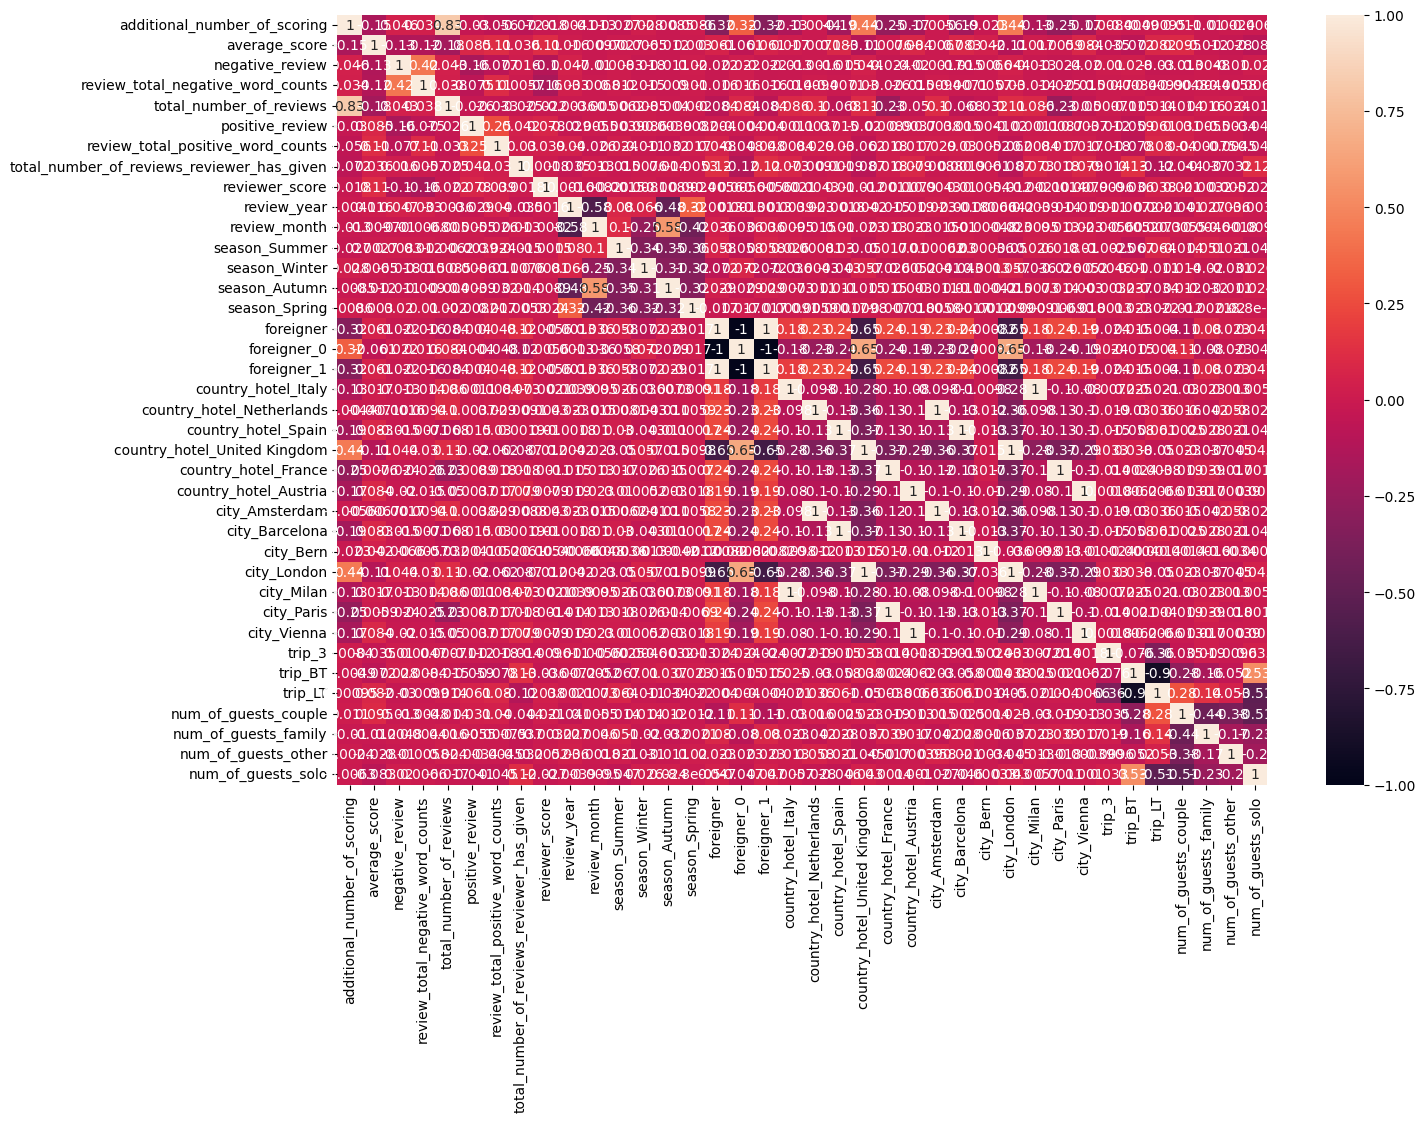

In [79]:
plt.rcParams['figure.figsize'] = (15,10)
#sns.heatmap(data.drop(['sample'], axis=1).corr(numeric_only=True), annot=True)
# for Kaggle
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [80]:
#data_clean.drop(['additional_number_of_scoring'], axis=1, inplace=True) #сильная корреляция признаков, НО при удалении метрика MAPE ухудшается

## Обучение модели 

In [81]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [82]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [83]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 38), (374007, 38), (374007, 37), (299205, 37), (74802, 37))

In [84]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [85]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [86]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished


In [87]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9458934028056288


<Axes: >

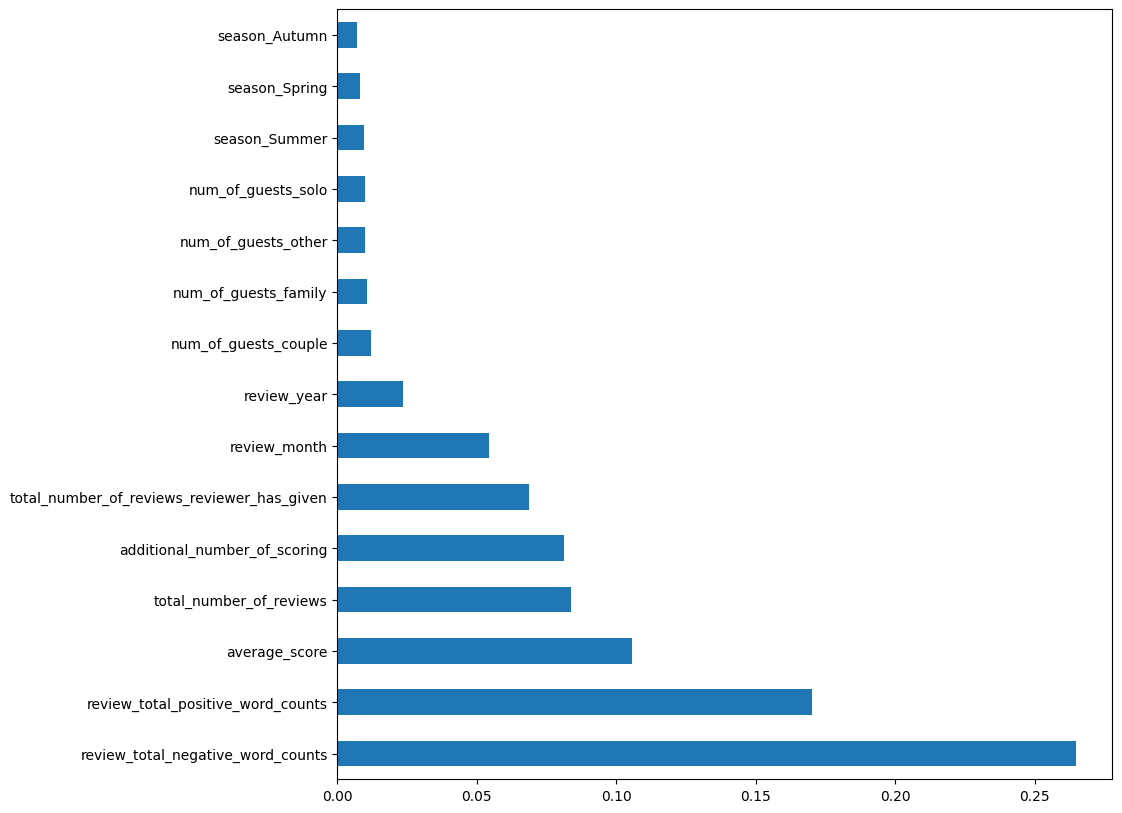

In [88]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [89]:
test_data.sample(10)

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,review_year,...,city_Milan,city_Paris,city_Vienna,trip_3,trip_BT,trip_LT,num_of_guests_couple,num_of_guests_family,num_of_guests_other,num_of_guests_solo
22844,168,8.1,0,0,2823,1,3,35,0.0,2,...,False,False,True,False,False,True,False,True,False,False
59389,1258,9.4,0,0,4204,1,12,1,0.0,2,...,False,False,False,False,False,True,True,False,False,False
92383,174,8.8,1,20,2464,1,93,7,0.0,2,...,False,False,True,False,False,True,True,False,False,False
27465,415,8.4,0,0,3340,1,5,3,0.0,1,...,False,False,False,False,False,True,False,False,False,True
71724,1427,8.8,1,11,4305,1,12,3,0.0,2,...,False,False,False,False,False,True,False,False,False,True
90882,44,8.5,1,40,413,1,17,9,0.0,1,...,False,True,False,False,False,True,False,True,False,False
11569,26,7.9,0,0,576,1,41,10,0.0,3,...,False,False,True,False,False,True,True,False,False,False
78994,161,8.6,1,36,761,1,24,3,0.0,2,...,False,False,False,False,False,True,True,False,False,False
104326,56,8.7,1,16,315,1,37,3,0.0,2,...,False,True,False,False,False,True,False,True,False,False
107689,1471,9.1,1,2,4802,1,2,2,0.0,1,...,False,False,False,False,True,False,False,False,False,True


In [90]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [91]:
sample_submission

,reviewer_score,id
0,8.359,488440
1,7.739,274649
2,8.092,374688
3,9.727,404352
4,9.013,451596
...,...,...
128930,8.631,495812
128931,8.497,315577
128932,7.456,511968
128933,9.475,303386


In [92]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.1s finished


In [93]:
predict_submission

array([8.359, 7.739, 8.092, ..., 7.456, 9.475, 6.474], shape=(128935,))

In [94]:
list(sample_submission)

['reviewer_score', 'id']

In [95]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.359,488440
1,7.739,274649
2,8.092,374688
3,9.727,404352
4,9.013,451596
5,8.644,302161
6,7.030,317079
7,7.852,13963
8,8.561,159785
9,7.999,195089
